<h2> Content-based filtering recommendation system based on the description overview of a movie </h2>

In [ ]:
from IPython.display import Image
Image(url='https://media.giphy.com/media/ie76dJeem4xBDcf83e/giphy.gif')

<h3> Introduction </h3>  
In this notebook, we will investigate whether the overview of a movie/series can effectively recommend similar movies. We will be using Google's NLP model (BERT) to analyse the overview of every movie and calculate the cosine similarity between each movie. We will then recommend the top 5 most similar movies based on the higest cosine similarity.

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=1375d34397b89f6700b702ffdf816abb33cee171eb08b3bb7a1e6ca0b796b3ac
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [ ]:
# data = pd.read_csv('/content/sample_data/imdb_top_1000.csv')
import ast, json
data = pd.read_csv('movies_metadata.csv')

# Randomly sample 30% of data (13k) to reduce computation time
data = data.sample(frac=0.3).reset_index()
data['overview'] = data['overview'].astype(str)
X = np.array(data.overview)

# Convert string to list
data['genres'] = data['genres'].apply(lambda x: ast.literal_eval(x))
# Extract genres from dictionary
data['genres'] = data['genres'].apply(lambda x: [d['name'] for d in x])
# Join all genres into one string
data['genres'] = data['genres'].apply(lambda x: ', '.join(x))

data.rename(columns={'overview':'Overview', 'genres':'Genre', 'original_title':'Movie Title'}, inplace=True)



C:\Users\tengwei\AppData\Local\Temp\ipykernel_10212\1005246825.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('movies_metadata.csv')


In [ ]:
data = data[['Genre','Overview','Movie Title']]
data.head()

,Genre,Overview,Movie Title
0,"War, Action",Captain Foster plans on raiding German-occupie...,Raid on Rommel
1,Documentary,Documentary about the quest for peace between ...,One Mile Away
2,"Action, Adventure, Comedy, Crime, Thriller","Roper, a hostage negotiator catches a murderou...",Metro
3,Documentary,"In WikiRebels, we learn about the early hacker...",WikiRebels: The Documentary
4,"Action, War, Thriller, Drama, Adventure",The movie takes place during World War II and ...,Ni liv: Historien om Jan Baalsrud


In [ ]:
data = pd.read_csv('tmdb_5000_movies.csv')
data['overview'] = data['overview'].astype(str)
X = np.array(data.overview)

# Convert string to list
data['genres'] = data['genres'].apply(lambda x: ast.literal_eval(x))
# Extract genres from dictionary
data['genres'] = data['genres'].apply(lambda x: [d['name'] for d in x])
# Join all genres into one string
data['genres'] = data['genres'].apply(lambda x: ', '.join(x))

data.rename(columns={'overview':'Overview', 'genres':'Genre', 'original_title':'Movie Title'}, inplace=True)
data = data[['Genre','Overview','Movie Title']]
data.head()

,Genre,Overview,Movie Title
0,"Action, Adventure, Fantasy, Science Fiction","In the 22nd century, a paraplegic Marine is di...",Avatar
1,"Adventure, Fantasy, Action","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,"Action, Adventure, Crime",A cryptic message from Bond’s past sends him o...,Spectre
3,"Action, Crime, Drama, Thriller",Following the death of District Attorney Harve...,The Dark Knight Rises
4,"Action, Adventure, Science Fiction","John Carter is a war-weary, former military ca...",John Carter


When working with textual data, we want to convert these text into numbers. More precisely we are converting a string of text into a vector.

But the question might lead to:
How should we convert the string in a smart way such that the vectors represent the text meaning?  
There are multiple ways of the conversion of text to vector, but we will use a BERT transformer model to aid us in our task.  
(Description of BERT transformer and what we gon do)

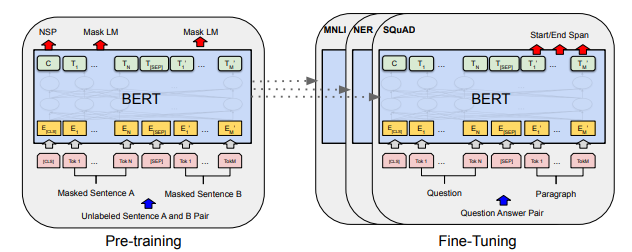

In [ ]:
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/427 [00:00<?, ?it/s]

<h1> Principal Components Analysis </h1>
We are using Principal Components Analysis to reduce the dimensionality of our dataset. It is so that we can represent our data in a vector form for data manipulatio. The values below gives an idea of the result of the text-vector conversion.

In [ ]:
X = np.array(embeddings)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

,0,1,2,3,4
0,-2.653935,-5.250760,0.386592,2.223001,-2.129659
1,2.193922,-4.775931,-2.002741,-2.317770,1.302007
2,-3.412721,-6.075070,1.471160,0.594530,2.546815
3,-1.220915,-3.260880,-2.238948,0.007898,0.132996
4,1.898446,-4.769771,-2.582882,-0.695283,-3.637367


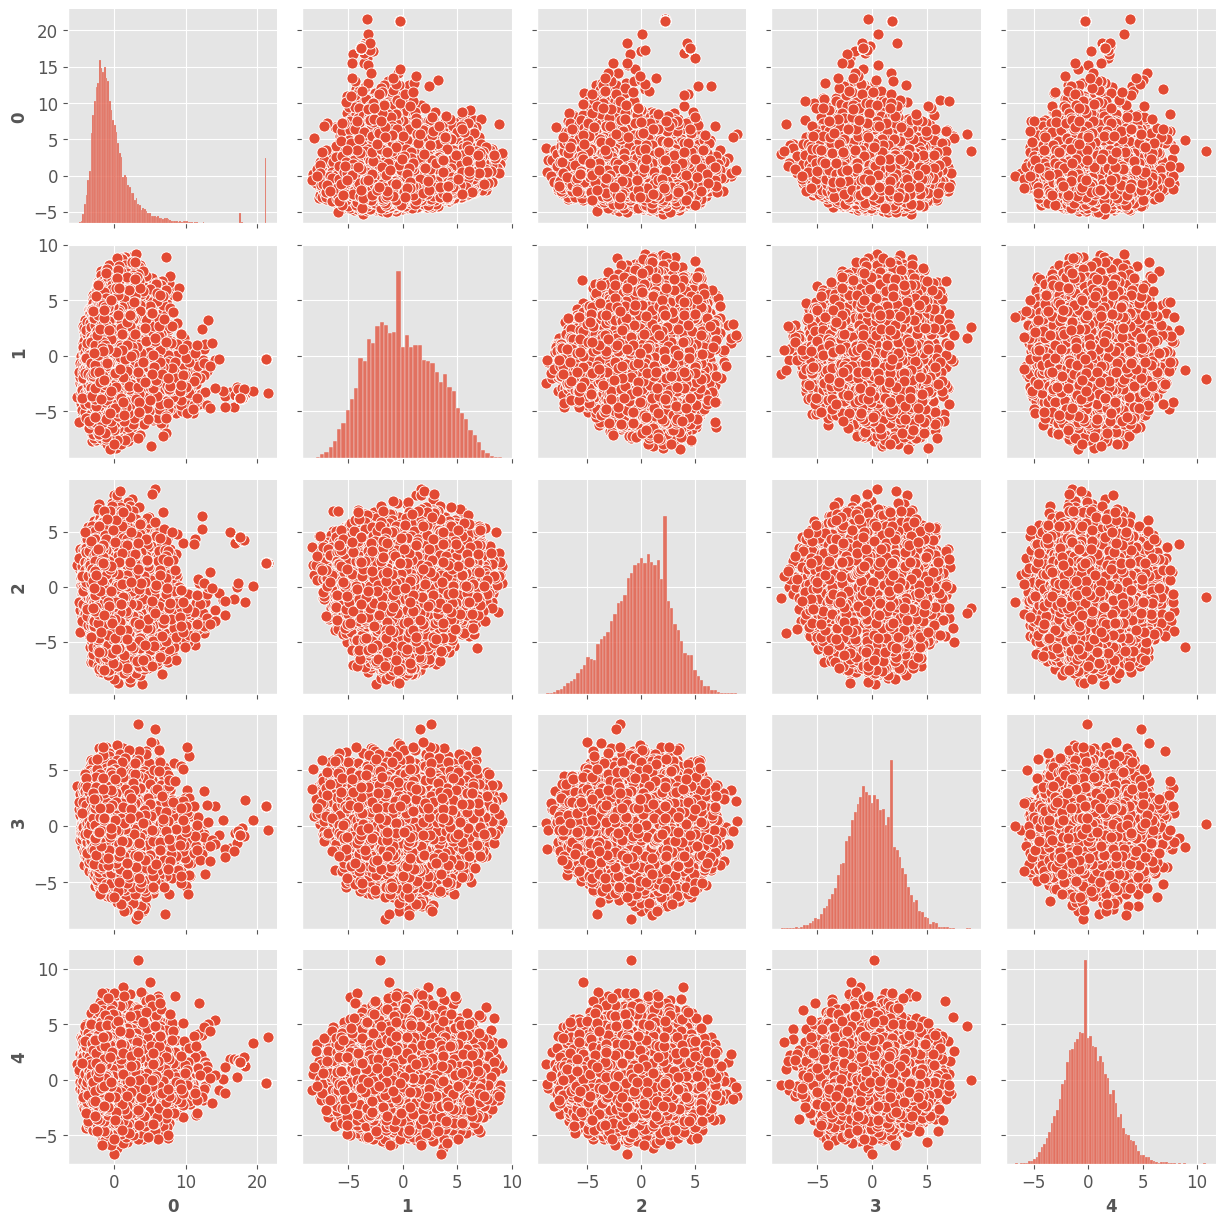

In [ ]:
sns.pairplot(pca_data)

Calculation of cosine similarity

In [ ]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))

In [ ]:
cos_sim_data.loc[2].sort_values(ascending=False)[1:6].tolist()

C:\Users\tengwei\AppData\Local\Temp\ipykernel_10212\2737284647.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cos_sim_data.loc[2].sort_values(ascending=False)[1:6].tolist()


[0.9286196231842041,
 0.8842873573303223,
 0.8841171860694885,
 0.8811525702476501,
 0.8742492198944092]

But why do we want to convert texts into vectors in the first place?

Well, because now that we have vectors we are able to do all the operations that you usually do on vectors :)

Imagine you are doing a classification task and you want to use Support Vector Machines. Well, of course, you will need to have vectors to do that. So if you have to classify a text you will first convert the text into a vector and then apply the SVM algorithm.

In our case we will use the vectorize test to find the similarity between two vectors. Our recommendation will be the (5) most similar vectors with the one we are considering.

This is an image explaining cosine similarity, courtesy of our lecture notes.
The closer the angle between the two vectors, the higher the cosine similarity, the more similar they are.
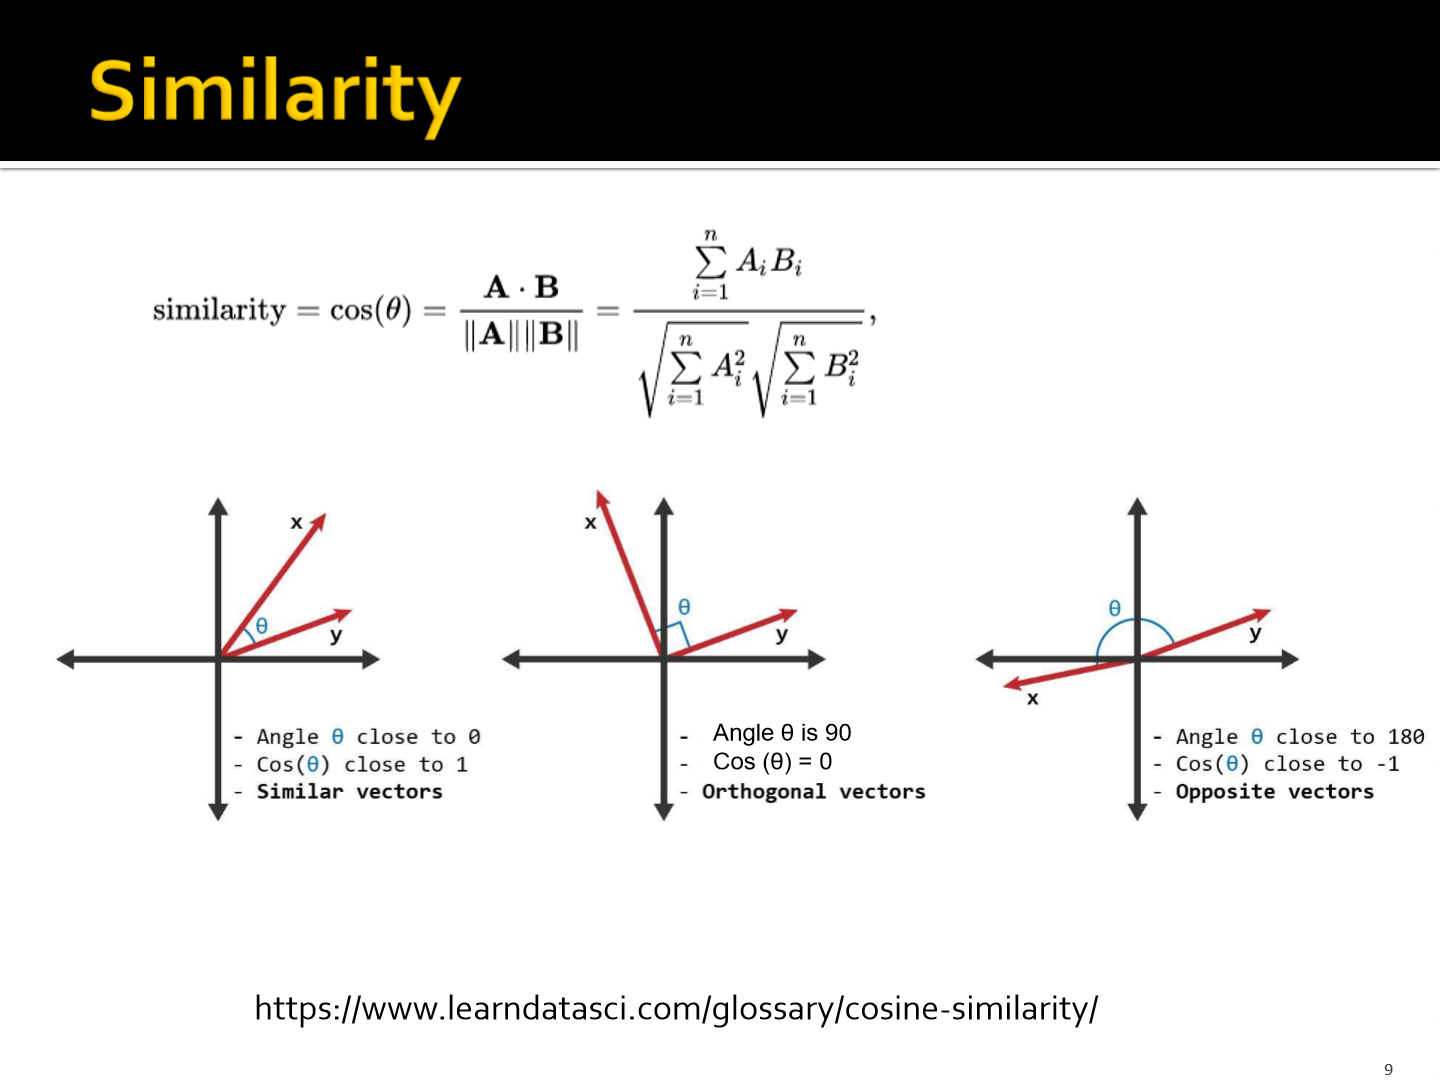

Let’s say x and y are two components (we’ll have way more than two). If a movie talks about science, space and rockets and another one talks more or less about the same stuff, we expect the two vectors to be close (smaller angle between the two vectors).
On the other hand, if the other movie is about a love story we will expect this vector to be far away (larger angle between the two vectors).

So here is what we’ll do:

1. Use BERT to convert our text into a vector  
2. Get the cosine similarity (the cosine of the angle between the two vectors) of a fixed movie (vector) and all the other ones  
3. Pick the movies (vectors) with the largest cosine similarity. We are going to pick 5 of them.  

Function to give movie recommendations

In [ ]:
def give_recommendations(index, print_recommendation = False, print_recommendation_plots = False, print_genres = False):
  index_recomm = cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]
  cosine_values = cos_sim_data.loc[index].sort_values(ascending=False).tolist()[1:6]
  movies_recomm =  data['Movie Title'].loc[index_recomm].values
  result = {'Movies':movies_recomm,'Index':index_recomm}
  k=1

  if print_recommendation==True:
    print('The watched movie: %s \n'%(data['Movie Title'].loc[index]))
    for movie in movies_recomm:
      print('The number %i recommended movie (cosine similarity= %s): %s \n'%(k, cosine_values[k-1], movie))
      k += 1

  if print_recommendation_plots==True:
    print('The plot of the watched movie (%s):\n %s \n' %(data['Movie Title'].loc[index], data['Overview'].loc[index]))
    k=1
    for q in range(len(movies_recomm)):
      plot_q = data['Overview'].loc[index_recomm[q]]
      print('The plot of the number %i recommended movie (%s):\n %s \n'%(k, movies_recomm[k-1], plot_q))
      k=k+1

  if print_genres==True:
    print('The genres of the watched movie:\n %s \n'%(data['Genre'].loc[index]))
    k=1
    for q in range(len(movies_recomm)):
      plot_q = data['Genre'].loc[index_recomm[q]]
      print('The plot of the number %i recommended movie (%s):\n %s \n'%(k, movies_recomm[k-1], plot_q))
      k=k+1

  return result

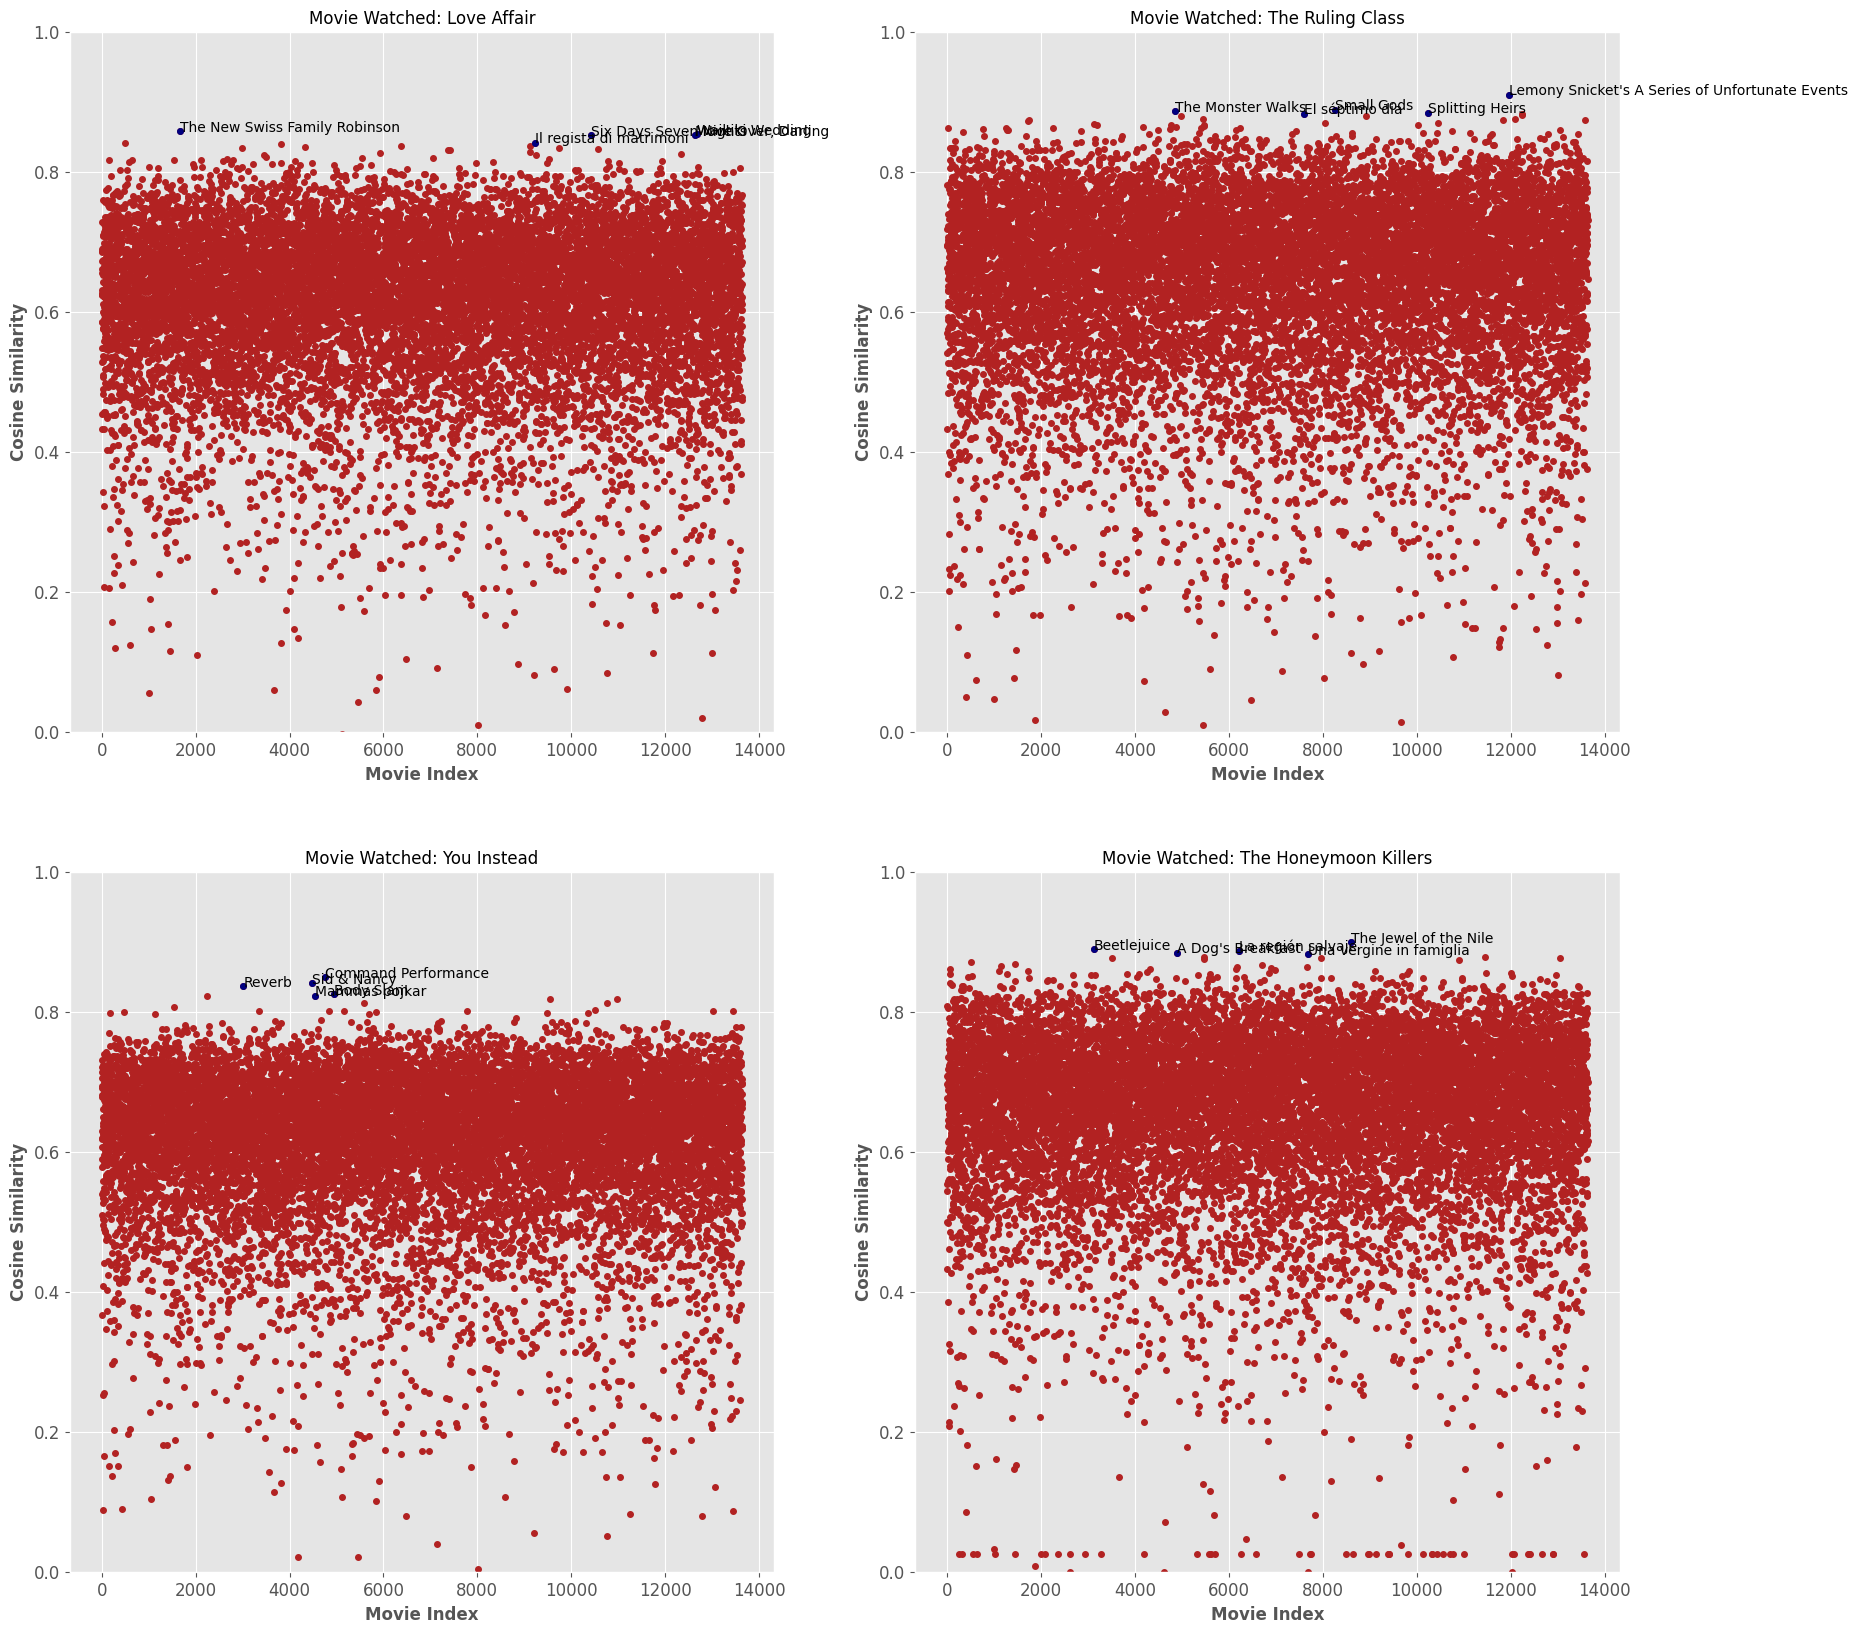

In [ ]:
plt.figure(figsize=(20,20))
for q in range(1,5):
  plt.subplot(2,2,q)
  # Randomly choosing a movie
  index = np.random.choice(np.arange(0,len(X)))
  to_plot_data = cos_sim_data.drop(index,axis=1)
  plt.plot(to_plot_data.loc[index],'.',color='firebrick')
  recomm_index = give_recommendations(index)
  x = recomm_index['Index']
  y = cos_sim_data.loc[index][x].tolist()
  m = recomm_index['Movies']
  plt.plot(x,y,'.',color='navy',label='Recommended Movies')
  plt.title('Movie Watched: '+data['Movie Title'].loc[index])
  plt.xlabel('Movie Index')
  k=0
  for x_i in x:
    plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
    k=k+1

  plt.ylabel('Cosine Similarity')
  plt.ylim(0,1)

In [ ]:
give_recommendations(2,True)

The watched movie: The Dark Knight 

The number 1 recommended movie (cosine similarity= 0.8290948867797852): Joker 

The number 2 recommended movie (cosine similarity= 0.8131625056266785): Dirty Harry 

The number 3 recommended movie (cosine similarity= 0.7927224040031433): Batman Begins 

The number 4 recommended movie (cosine similarity= 0.7851702570915222): Guardians of the Galaxy 

The number 5 recommended movie (cosine similarity= 0.7791411876678467): Death Note: Desu nôto 



{'Movies': array(['Joker', 'Dirty Harry', 'Batman Begins', 'Guardians of the Galaxy',
        'Death Note: Desu nôto'], dtype=object),
 'Index': [33, 853, 155, 339, 762]}

In [ ]:
give_recommendations(2,False,True)

The plot of the watched movie (The Dark Knight):
 When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice. 

The plot of the number 1 recommended movie (Joker):
 In Gotham City, mentally troubled comedian Arthur Fleck is disregarded and mistreated by society. He then embarks on a downward spiral of revolution and bloody crime. This path brings him face-to-face with his alter-ego: the Joker. 

The plot of the number 2 recommended movie (Dirty Harry):
 When a madman calling himself "the Scorpio Killer" menaces the city, tough-as-nails San Francisco Police Inspector "Dirty" Harry Callahan is assigned to track down and ferret out the crazed psychopath. 

The plot of the number 3 recommended movie (Batman Begins):
 After training with his mentor, Batman begins his fight to free crime-ridden Gotham City from corruption. 

The plot of the number 4 recommended mo

{'Movies': array(['Joker', 'Dirty Harry', 'Batman Begins', 'Guardians of the Galaxy',
        'Death Note: Desu nôto'], dtype=object),
 'Index': [33, 853, 155, 339, 762]}

In [ ]:
give_recommendations(65,True,True,True)

The watched movie: Canyon Passage 

The number 1 recommended movie (cosine similarity= 0.8454042673110962): Gilda 

The number 2 recommended movie (cosine similarity= 0.8185625672340393): Dragstrip Girl 

The number 3 recommended movie (cosine similarity= 0.8140363693237305): Inventing the Abbotts 

The number 4 recommended movie (cosine similarity= 0.8026950359344482): Ishq 

The number 5 recommended movie (cosine similarity= 0.8006224632263184): The Villain 

The plot of the watched movie (Canyon Passage):
 Businessman Logan Stuart is torn between his love of two very different women in 1850s Oregon and his loyalty to a compulsive gambler friend who goes over the line. 

The plot of the number 1 recommended movie (Gilda):
 Just arrived in Argentina, small-time crooked gambler Johnny Farrell is saved from a gunman by sinister Ballin Mundson, who later makes Johnny his right-hand man. But their friendship based on mutual lack of scruples is strained when Mundson returns from a trip wit

{'Movies': array(['Gilda', 'Dragstrip Girl', 'Inventing the Abbotts', 'Ishq',
        'The Villain'], dtype=object),
 'Index': [9341, 5229, 8206, 13459, 801]}

Storing our top 5 generated movie recommendation for every movie into a dataframe

In [ ]:
recomm_list = []
for i in range(len(X)):
  recomm_i = give_recommendations(i)
  recomm_list.append(recomm_i['Movies'])
recomm_data = pd.DataFrame(recomm_list,columns=['First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation'])
recomm_data['Watched Movie'] = data['Movie Title']
recomm_data = recomm_data[['Watched Movie','First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation']]

In [ ]:
recomm_data.sample(frac=1).head()

,Watched Movie,First Recommendation,Second Recommendation,Third Recommendation,Fourth Recommendation,Fifth Recommendation
2145,Black Shampoo,Le Gendarme de Saint-Tropez,Someone to Watch Over Me,Cliente,Shut Up and Kiss Me!,Once Is Not Enough
1090,Open Secret,Amu,Cookie,Cleveland Abduction,Sand Castles,سیب
3209,Jørgen + Anne = sant,She's the Man,Monster High: 13 Wishes,내 마음의 풍금,The Babysitter,A Royal Christmas
3539,No Good Deed,집으로 가는 길,American Violet,"Ieri, oggi, domani",Le Vilain,The Hollow
2881,Viikossa aikuiseksi,Summer Camp,Heavyweights,Simon Says,Vacation,Africa United
